In [8]:
import pandas as pd
import numpy as np
import pvlib
from solarspatialtools import irradiance
from solarspatialtools import cmv
from solarspatialtools import spatial

from solarspatialtools.synthirrad.cloudfield import get_timeseries_stats, cloudfield_timeseries

import matplotlib.pyplot as plt

Load sample timeseries data and convert it to clear sky index

In [11]:
# #### Load Timeseries Data

datafn = "data/hope_melpitz_1s.h5"
twin = pd.date_range('2013-09-08 9:15:00', '2013-09-08 10:15:00', freq='1s', tz='UTC')
data = pd.read_hdf(datafn, mode="r", key="data")
data_i = data[40]

# Get the time series for a single sensor and convert it to a clear sky index.
# Record some statistics about it.
pos = pd.read_hdf(datafn, mode="r", key="latlon")
loc = pvlib.location.Location(np.mean(pos['lat']), np.mean(pos['lon']))
cs_ghi = loc.get_clearsky(data_i.index, model='simplified_solis')['ghi']
cs_ghi = 1000/max(cs_ghi) * cs_ghi  # Rescale (possible scaling on
kt = pvlib.irradiance.clearsky_index(data_i, cs_ghi, 2)


Get the Cloud Motion Vector for the Timeseries

In [12]:
# Get the Cloud Motion Vector for the Timeseries
pos_utm = pd.read_hdf(datafn, mode="r", key="utm")
kt_all = irradiance.clearsky_index(data, cs_ghi, 2)
cld_spd, cld_dir, _ = cmv.compute_cmv(kt_all, pos_utm, reference_id=None, method='jamaly')
cld_vec_rect = spatial.pol2rect(cld_spd, cld_dir)

print(f"Cld Speed  {cld_spd:8.2f}, Cld Dir {np.rad2deg(cld_dir):8.2f}")

Cld Speed     19.67, Cld Dir    90.70


Redefine the positions to represent the rotated view in the cloud motion vector space

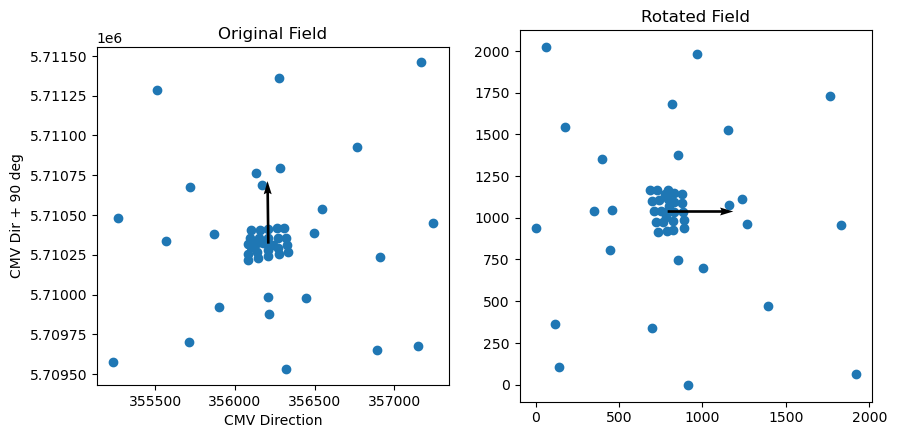

In [14]:
# Rotate the sensor positions by -cld dir to position the incoming clouds
# toward the upwind side of the plant. Shift to zero out the minimum value.
rot = spatial.rotate_vector((pos_utm['E'], pos_utm['N']), theta=-cld_dir)
pos_utm_rot = pd.DataFrame({'X': rot[0] - np.min(rot[0]),
                            'Y': rot[1] - np.min(rot[1])},
                           index=pos_utm.index)

# plot the original field and the rotated field side by side in two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(pos_utm['E'], pos_utm['N'])
axs[0].set_title('Original Field')
axs[0].quiver(pos_utm['E'][40], pos_utm['N'][40], 200 * cld_vec_rect[0], 200 * cld_vec_rect[1], scale=10, scale_units='xy')
axs[0].set_xlabel('East')
axs[0].set_ylabel('North')
axs[1].scatter(pos_utm_rot['X'], pos_utm_rot['Y'])
axs[1].quiver(pos_utm_rot['X'][40], pos_utm_rot['Y'][40], 200*cld_spd, 0, scale=10, scale_units='xy')
axs[1].set_title('Rotated Field')
axs[0].set_xlabel('CMV Direction')
axs[0].set_ylabel('CMV Dir + 90 deg')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')


Get statistics on the timeseries that will be used to scale the synthetic timeseries.

In [13]:
ktmean, kt1pct, ktmax, frac_clear, vs, weights, scales = get_timeseries_stats(kt, plot=False)

Generate a spatiotemporal relationship as a first step of creating the cloud field that represents the cloud data

In [15]:
# #### Generate the Simulated Cloud Field

# Calculate the size of the field
x_extent = np.abs(np.max(pos_utm_rot['X']) - np.min(pos_utm_rot['X']))
y_extent = np.abs(np.max(pos_utm_rot['Y']) - np.min(pos_utm_rot['Y']))
t_extent = (np.max(twin) - np.min(twin)).total_seconds()
dt = (twin[1] - twin[0]).total_seconds()

# Convert space to time
spatial_time_x = x_extent / cld_spd
spatial_time_y = y_extent / cld_spd

# This now represents the time to space relationship in seconds, so each pixel of the field represents a 1 second step.
# Our steps in X represent 1 second forward or backward in EITHER along-cloud space or time
# Our steps in Y represent 1 "cloud second" left or right perpendicular to the motion axis
# We actually have to oversize things a bit because if the field is too small, we can't
# halve its size a sufficient number of times.
xt_size = int(np.ceil(spatial_time_x + t_extent))
yt_size = int(np.ceil(spatial_time_y))


Unified methodology

In [ ]:
np.random.seed(42)  # Do seeding for repeatability

field_final = cloudfield_timeseries(weights, scales, (xt_size, yt_size), frac_clear, ktmean, ktmax, kt1pct)



Internal methodology of the cloud field generation

In [ ]:
from solarspatialtools.synthirrad.cloudfield import _stack_random_field, _calc_clear_mask, _find_edges, _scale_field_lave

internal_size = (xt_size, yt_size)
internal_edgesmoothing = 3
internal_cfield = _stack_random_field(weights, scales, internal_size, plot=False)
internal_clear_mask = _stack_random_field(weights, scales, internal_size)
internal_clear_mask = _calc_clear_mask(internal_clear_mask, frac_clear, plot=False)  # 0 is cloudy, 1 is clear

edges, smoothed = _find_edges(internal_clear_mask, internal_edgesmoothing)

internal_field_final = _scale_field_lave(internal_cfield, internal_clear_mask, smoothed, ktmean, ktmax, kt1pct, plot=False)

Plots about it

In [ ]:
# Plot a timeseries
plt.plot(field_final[:,1:5])

plt.figure()
plt.plot(kt_all.iloc[:,1:5])
plt.show()

# Convert space to time to extract time series
xpos = pos_utm_rot['X'] - np.min(pos_utm_rot['X'])
ypos = pos_utm_rot['Y'] - np.min(pos_utm_rot['Y'])
xpos_temporal = xpos / cld_spd
ypos_temporal = ypos / cld_spd

sim_kt = pd.DataFrame(index=twin, columns=pos_utm_rot.index)
for sensor in pos_utm_rot.index:
    x = int(xpos_temporal[sensor])
    y = int(ypos_temporal[sensor])
    sim_kt[sensor] = field_final[x:x+int(t_extent)+1, y]

plt.plot(sim_kt[[40,42]])
plt.figure()
plt.plot(kt_all[[40,42]])
plt.show()




# Compare Hist of CS Index
plt.hist(kt, bins=50)
plt.hist(field_final[:,1], bins=50, alpha=0.5)

# Ramp Rate
plt.figure()
plt.hist(np.diff(kt), bins=50)
plt.hist(np.diff(field_final[:,1]), bins=200, alpha=0.5)
plt.show()
